In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from thefuzz import fuzz
from thefuzz import process

cars = pd.read_csv("./concatenated_data.csv", index_col=0)
del cars["description"]
cars.columns = [
    "brand",
    "model",
    "price",
    "mileage",
    "year",
    "location",
    "date_added",
    "body_type",
    "fuel",
    "power",
    "transmission",
    "color",
    "price_new",
    "engine_size",
]
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9437 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         9411 non-null   object 
 1   model         9411 non-null   object 
 2   price         9432 non-null   float64
 3   mileage       9411 non-null   float64
 4   year          9411 non-null   object 
 5   location      9421 non-null   object 
 6   date_added    3336 non-null   object 
 7   body_type     9191 non-null   object 
 8   fuel          9411 non-null   object 
 9   power         9411 non-null   object 
 10  transmission  9411 non-null   object 
 11  color         9400 non-null   object 
 12  price_new     1955 non-null   float64
 13  engine_size   5855 non-null   object 
dtypes: float64(3), object(11)
memory usage: 1.1+ MB


# Overview


In [78]:
cars.describe()


,price,mileage,price_new
count,9.432000e+03,9.411000e+03,1955.000000
mean,3.309366e+07,2.361327e+12,171507.106905
std,1.645900e+09,1.619689e+14,136366.008481
min,-1.000000e+00,-2.200000e+05,29510.000000
25%,8.000000e+03,2.400000e+04,79990.000000
50%,3.300000e+04,1.010000e+05,136480.000000
75%,5.992500e+04,1.800000e+05,215000.000000
max,1.111111e+11,1.111111e+16,908000.000000


In [79]:
def summary_statistics(dataset):
    print(" summary statistics")
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.nanmedian(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    q1 = np.round(dataset.quantile(0.25), 2)
    q3 = np.round(dataset.quantile(0.75), 2)
    # Interquartile range
    iqr = np.round(q3 - q1, 2)
    print("Min: %s" % min_value)
    print("Mean: %s" % mean)
    print("Max: %s" % max_value)
    print("25th percentile: %s" % q1)
    print("Median: %s" % median)
    print("75th percentile: %s" % q3)
    print("Interquartile range (IQR): %s" % iqr)

# Strings


Applying str.title() to each column and specifying the field datatype


In [80]:
for col in cars.columns:
    if cars[col].dtype == "object":
        cars[col] = cars[col].str.title()

In [81]:
def explore_strings(df, column):
    # Specifying the field datatype
    df[column] = df[column].fillna("").astype(str)
    strings = df[column].unique()
    print(f"distinct {column}s : ", strings)
    print(f"number of distinct {column}s : ", len(strings) - 1)  # do not count ""
    return strings

## Location


Exploring the values of "location" column


In [82]:
locations = explore_strings(cars, "location")

distinct locations :  ['Ariana' 'Tunis' 'Ben Arous' 'Bizerte' 'Monastir' 'Béja' 'La Manouba'
 'Sousse' 'Nabeul' 'Sidi Bouzid' 'Gafsa' 'Kairouan' 'Sfax' 'Mahdia'
 'Tozeur' 'Médenine' 'Kasserine' 'Le Kef' 'Gabès' 'Zaghouan' 'Jendouba'
 'Kébili' 'Siliana' 'Manouba' 'Gabes' 'Tataouine' '']
number of distinct locations :  26


In [83]:
def get_matches(df, column, string_to_match, min_ratio=50):
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = process.extract(
        string_to_match, strings, limit=10, scorer=fuzz.token_sort_ratio
    )
    # only get matches with a ratio >= min_ratio
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    return close_matches

In [84]:
def explore_matches(df, column, ratio=60):
    strings = df[column].unique()
    seen = set()
    for s in strings:
        if s in seen:
            continue
        if s == "":
            continue
        close_matches = get_matches(df, column, s, ratio)
        seen.update(close_matches)
        if len(close_matches) >= 2:
            print(f"close matches of {s}: {close_matches}")

In [85]:
explore_matches(cars, "location")

close matches of Ariana: ['Ariana', 'Siliana']
close matches of La Manouba: ['La Manouba', 'Manouba']
close matches of Gafsa: ['Gafsa', 'Gabès', 'Gabes']
close matches of Kairouan: ['Kairouan', 'Zaghouan']
close matches of Jendouba: ['Jendouba', 'Manouba']


Unify and fix the values of the "location" column


In [86]:
my_dict = {"La Manouba": "Manouba", "Gabès": "Gabes"}
cars.replace({"location": my_dict}, inplace=True)

In [87]:
locations = explore_strings(cars, "location")

distinct locations :  ['Ariana' 'Tunis' 'Ben Arous' 'Bizerte' 'Monastir' 'Béja' 'Manouba'
 'Sousse' 'Nabeul' 'Sidi Bouzid' 'Gafsa' 'Kairouan' 'Sfax' 'Mahdia'
 'Tozeur' 'Médenine' 'Kasserine' 'Le Kef' 'Gabes' 'Zaghouan' 'Jendouba'
 'Kébili' 'Siliana' 'Tataouine' '']
number of distinct locations :  24


## Color


In [88]:
colors = explore_strings(cars, "color")

distinct colors :  ['Blanc' 'Rouge' 'Noir' 'Gris Shark' 'Beige' 'Bleu' 'Gris Argent'
 'Gris Anthracite' 'Autre' 'Orange' 'Marron' 'Vert' 'Jaune' 'Aubergine'
 'Bleu Roi' 'Gris' 'Bronze' 'Gris Métallisé' 'Gris Foncé' 'Gris Titanuim'
 'Bleu Gris' 'Noire' 'Miel' 'Blanc Cristal' '' 'Bleu/Gris' 'Mauve Gris'
 'Gris Charbon' '*****' 'Blanche' 'Grise' 'Verte' 'Bleu Métallisée'
 'Grise Metalisee' 'Bleu Métallisé' 'Gris Magnetic' 'Gris Clair Métallisé'
 "Feuille D'Argent" 'Maran' 'Grise Métallisée' 'Rouge Bordeaux' 'Camel'
 'Grenadine' 'Titanium' 'Champagne' 'Multicolore' 'Argent' 'Doré' 'Violet'
 'Corail']
number of distinct colors :  49


Brouillon


In [89]:
# get all the words that match "gris"
matches = process.extract("gris", colors, limit=20, scorer=fuzz.token_sort_ratio)
# take a look at them to choose min_ratio
matches

[('Gris', 100),
 ('Grise', 89),
 ('Gris Foncé', 62),
 ('Bleu Gris', 62),
 ('Bleu/Gris', 62),
 ('Gris Shark', 57),
 ('Mauve Gris', 57),
 ('Gris Argent', 53),
 ('Gris Métallisé', 50),
 ('Gris Charbon', 50),
 ('Gris Titanuim', 47),
 ('Gris Magnetic', 47),
 ('Grenadine', 46),
 ('Grise Métallisée', 44),
 ('Gris Anthracite', 42),
 ('Grise Metalisee', 42),
 ('Corail', 40),
 ('Gris Clair Métallisé', 36),
 ('Blanc Cristal', 35),
 ('Bleu Roi', 33)]

In [90]:
colors_gris = ["gris" if c.lower().startswith("gris") else c for c in colors]

colors_gris = [c[:-4] if c.lower().endswith("gris") else c for c in colors_gris]

matches = process.extract("Gris a", colors, limit=30, scorer=fuzz.token_sort_ratio)
score = fuzz.token_sort_ratio("gris ", "Gris Anthracite")
print(score)
matches


42


[('Gris', 80),
 ('Grise', 73),
 ('Gris Argent', 71),
 ('Gris Foncé', 67),
 ('Bleu Gris', 67),
 ('Bleu/Gris', 67),
 ('Gris Charbon', 67),
 ('Gris Anthracite', 57),
 ('Blanc Cristal', 53),
 ('Gris Shark', 50),
 ('Mauve Gris', 50),
 ('Gris Clair Métallisé', 50),
 ('Gris Métallisé', 44),
 ('Bleu Roi', 43),
 ('Gris Titanuim', 42),
 ('Gris Magnetic', 42),
 ('Aubergine', 40),
 ('Grise Métallisée', 40),
 ('Grenadine', 40),
 ('Grise Metalisee', 38),
 ('Autre', 36),
 ('Maran', 36),
 ('Orange', 33),
 ('Marron', 33),
 ('Bleu Métallisé', 33),
 ('Argent', 33),
 ('Corail', 33),
 ('Bleu Métallisée', 32),
 ('Rouge Bordeaux', 30),
 ('Titanium', 29)]

In [91]:
def replace_matches_in_column(df, column, string_to_match, min_ratio=47):
    # only get matches with a ratio > 90
    close_matches = get_matches(df, column, string_to_match, min_ratio)

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

In [92]:
def replace_colors(df, column, color):
    shades = [c for c in column if c.lower().strip().startswith(color)]
    rows_with_matches = df["color"].isin(shades)
    df.loc[rows_with_matches, "color"] = color.title()

In [93]:
replace_colors(cars, colors, "gris")
replace_colors(cars, colors, "bleu")
replace_colors(cars, colors, "blanc")
replace_colors(cars, colors, "vert")
replace_colors(cars, colors, "rouge")
replace_colors(cars, colors, "noir")


Unify and fix the values of the "color" column


In [94]:
my_dict = {
    "Argent": "Gris",
    "Feuille D'Argent": "Gris",
    "Titanium": "Gris",
    "Miel": "Doré",
    "Champagne": "Jaune",
    "Grenadine": "Rouge",
    "Rouge Bordeaux": "Rouge",
    "Mauve Gris": "Mauve",
    "Aubergine": "Violet",
    "Maran": "Marron",
    "Corail": "Orange",
}
cars.replace({"color": my_dict}, inplace=True)


If color is "**\***" -> color = nan


In [95]:
specified_color = cars["color"] == "*****"
cars[specified_color] = np.nan

In [96]:
colors_clean = explore_strings(cars, "color")

distinct colors :  ['Blanc' 'Rouge' 'Noir' 'Gris' 'Beige' 'Bleu' 'Autre' 'Orange' 'Marron'
 'Vert' 'Jaune' 'Violet' 'Bronze' 'Doré' '' 'Mauve' 'Camel' 'Multicolore']
number of distinct colors :  17


## Model


In [97]:
models = explore_strings(cars, "model")

distinct models :  ['T Roc' 'Zs' 'Cerato 5P' 'Sportage' 'A4' 'Partner' 'Classe C' 'Gla' 'Q3'
 'Classe B' 'Golf 7' 'Classe C Coupe' 'Serie 3' 'Logan Mcv' 'A3'
 'Ecosport' 'Serie 4 Gran Coupe' '208' 'Ml' 'Clio' 'D Max' '3008' 'Polo'
 'A5 Sportback' 'H 1' 'Cla' 'Classe E Coupe' 'Mondeo' 'Cayenne' '206 Plus'
 'Rio 5P' 'Hs' '3' 'Serie 5' 'Tivoli' 'Compass' '206' 'Q7' '308' 'Leon'
 'Jetta' 'Formentor' 'Macan' 'Qashqai' 'Q2' 'Serie 7' 'Tiguan' 'Fusion'
 'H6' 'Golf 8' 'Focus' 'C3' 'A5 Coupe' 'Staria' 'Viano' 'Doblo' 'H2'
 'Rexton' 'Jolion' 'Discovery' '2008' 'Symbol' 'Passat Cc'
 'Discovery Sport' 'Tiggo 3' 'Classe S' 'E Pace' 'Range Rover Evoque'
 'Ds3' 'Classe A' 'Qx56' 'Polo Sedan' 'F Pace' 'Classe E' 'Seltos' 'Iris'
 'Patrol' 'Ateca' 'Gc 6' 'Picanto' 'Arona' 'Gs' 'Amarok' 'A3 Berline'
 'A3 Sportback' 'Sx3' 'City' 'S5' 'C Hr' 'Mustang' 'Tipo Berline' 'Golf 6'
 'Serie 2 Active Tourer' 'M4' 'Tipo' 'Transit' 'Megane Sedan'
 'Punto Classic' 'Glc Coupe' 'Serie 1 5P' 'Kuv 100' 'Renegade'
 'Partne

In [98]:
already = set()
k = 0
for m in models:
    if m == "":
        continue
    if m in already:
        continue

    close_matches = get_matches(cars, "model", m, 80)
    already.update(set(close_matches))
    if len(close_matches) >= 2:
        k += 1
        print(f"close matches of {m}: {close_matches}")


print(k)

close matches of Cerato 5P: ['Cerato 5P', 'Cerato']
close matches of A4: ['A4', 'Ax4']
close matches of Classe C: ['Classe C', 'Classe Cla', 'Classe B', 'Classe A']
close matches of Gla: ['Gla', 'Gl']
close matches of Golf 7: ['Golf 7', 'Golf 8', 'Golf 6', 'Golf 5', 'Golf 4', 'Golf 2', 'Golf 3', 'Golf']
close matches of Classe C Coupe: ['Classe C Coupe', 'Classe E Coupe']
close matches of Serie 3: ['Serie 3', 'Serie 5', 'Serie 7', 'Serie 4', 'Serie 1', 'Serie 2', 'Serie 3 Gt']
close matches of Serie 4 Gran Coupe: ['Serie 4 Gran Coupe', 'Serie 2 Gran Coupe', 'Serie 4 Coupe']
close matches of 208: ['208', '2008']
close matches of D Max: ['D Max', 'D-Max']
close matches of 3008: ['3008', '308', '300']
close matches of Polo: ['Polo', 'Polo 7', 'Polo 6', 'Polo 4', 'Polo 3']
close matches of A5 Sportback: ['A5 Sportback', 'A3 Sportback', 'A7 Sportback', 'A1 Sportback', 'Q5 Sportback', 'Q3 Sportback']
close matches of H 1: ['H 1', 'H-1']
close matches of Cla: ['Cla', 'Cl']
close matches of 20

Unify and fix the values of the "model" column


In [99]:
my_dict = {
    "D-Max": "D Max",
    "H-1": "H 1",
    "Over.Range Rover Sport": "Range Rover Sport",
    "Hr-V": "Hr V",
    "Bt-50": "Bt 50",
    "Hi.Lux": "Hilux",
    "Cx 5": "Cx 5",
    "C-Elysee": "C Elysée",
    "C Elysee": "C Elysée",
    "Cx-9": "Cx 9",
    "Autres": "Autre",
    "X-Trail": "X Trail",
    "Country Man": "Countryman",
    ".Country Man": "Countryman",
    "PickUp": "Pickup",
    "Cee'D": "Ceed",
    "C'Eed": "Ceed",
    "Serie 1": "Série 1",
    "Hi.Ace": "Hi Ace",
    "Gol": "Golf",
    "Volkswagen.Golf": "Golf",
    "Volkswagen.Polo": "Polo",
}
cars.replace({"model": my_dict}, inplace=True)


In [100]:
models_clean = explore_strings(cars, "model")

distinct models :  ['T Roc' 'Zs' 'Cerato 5P' 'Sportage' 'A4' 'Partner' 'Classe C' 'Gla' 'Q3'
 'Classe B' 'Golf 7' 'Classe C Coupe' 'Serie 3' 'Logan Mcv' 'A3'
 'Ecosport' 'Serie 4 Gran Coupe' '208' 'Ml' 'Clio' 'D Max' '3008' 'Polo'
 'A5 Sportback' 'H 1' 'Cla' 'Classe E Coupe' 'Mondeo' 'Cayenne' '206 Plus'
 'Rio 5P' 'Hs' '3' 'Serie 5' 'Tivoli' 'Compass' '206' 'Q7' '308' 'Leon'
 'Jetta' 'Formentor' 'Macan' 'Qashqai' 'Q2' 'Serie 7' 'Tiguan' 'Fusion'
 'H6' 'Golf 8' 'Focus' 'C3' 'A5 Coupe' 'Staria' 'Viano' 'Doblo' 'H2'
 'Rexton' 'Jolion' 'Discovery' '2008' 'Symbol' 'Passat Cc'
 'Discovery Sport' 'Tiggo 3' 'Classe S' 'E Pace' 'Range Rover Evoque'
 'Ds3' 'Classe A' 'Qx56' 'Polo Sedan' 'F Pace' 'Classe E' 'Seltos' 'Iris'
 'Patrol' 'Ateca' 'Gc 6' 'Picanto' 'Arona' 'Gs' 'Amarok' 'A3 Berline'
 'A3 Sportback' 'Sx3' 'City' 'S5' 'C Hr' 'Mustang' 'Tipo Berline' 'Golf 6'
 'Serie 2 Active Tourer' 'M4' 'Tipo' 'Transit' 'Megane Sedan'
 'Punto Classic' 'Glc Coupe' 'Serie 1 5P' 'Kuv 100' 'Renegade'
 'Partne

## Brand


In [101]:
brands = explore_strings(cars, "brand").sort()

distinct brands :  ['Volkswagen' 'Mg' 'Kia' 'Audi' 'Peugeot' 'Mercedes Benz' 'Bmw' 'Dacia'
 'Ford' 'Renault' 'Isuzu' 'Hyundai' 'Porsche' 'Mazda' 'Ssangyong' 'Jeep'
 'Seat' 'Cupra' 'Nissan' 'Haval' 'Citroen' 'Fiat' 'Land Rover' 'Chery'
 'Jaguar' 'Infiniti' 'Wallyscar' 'Geely' 'Dongfeng' 'Honda' 'Toyota'
 'Great Wall' 'Mahindra' 'Hyundai Trucks' 'Suzuki' 'Byd' 'Skoda' 'Foton'
 'Iveco' 'Opel' 'Mitsubishi' 'Baic Yx' 'Mini' 'Dfsk' 'Chevrolet'
 'Alfa Romeo' 'Gac Motor' 'Hummer' 'Volvo' 'Ds' 'Tata' 'Smart' 'Lada'
 'Lancia' 'Maserati' 'Dodge' 'Land-Rover' 'Mercedes' '' 'Autre Marque'
 'Mercedes-Benz' 'Autres' 'Rover' 'Ac' 'Daewoo' 'Masey Ferguson' 'Gmc'
 'Aston Martin' 'Chrysler' 'Daihatsu' 'Man' 'Changhe']
number of distinct brands :  71


In [102]:
explore_matches(cars, "brand", 70)

close matches of Mercedes Benz: ['Mercedes Benz', 'Mercedes-Benz', 'Mercedes']
close matches of Dacia: ['Dacia', 'Lancia']
close matches of Isuzu: ['Isuzu', 'Suzuki']
close matches of Land Rover: ['Land Rover', 'Land-Rover']


In [103]:
my_dict = {
    "Mercedes-Benz": "Mercedes Benz",
    "Mercedes": "Mercedes Benz",
    "Land-Rover": "Land Rover",
}
cars.replace({"brand": my_dict}, inplace=True)

In [104]:
brands = explore_strings(cars, "brand")

distinct brands :  ['Volkswagen' 'Mg' 'Kia' 'Audi' 'Peugeot' 'Mercedes Benz' 'Bmw' 'Dacia'
 'Ford' 'Renault' 'Isuzu' 'Hyundai' 'Porsche' 'Mazda' 'Ssangyong' 'Jeep'
 'Seat' 'Cupra' 'Nissan' 'Haval' 'Citroen' 'Fiat' 'Land Rover' 'Chery'
 'Jaguar' 'Infiniti' 'Wallyscar' 'Geely' 'Dongfeng' 'Honda' 'Toyota'
 'Great Wall' 'Mahindra' 'Hyundai Trucks' 'Suzuki' 'Byd' 'Skoda' 'Foton'
 'Iveco' 'Opel' 'Mitsubishi' 'Baic Yx' 'Mini' 'Dfsk' 'Chevrolet'
 'Alfa Romeo' 'Gac Motor' 'Hummer' 'Volvo' 'Ds' 'Tata' 'Smart' 'Lada'
 'Lancia' 'Maserati' 'Dodge' '' 'Autre Marque' 'Autres' 'Rover' 'Ac'
 'Daewoo' 'Masey Ferguson' 'Gmc' 'Aston Martin' 'Chrysler' 'Daihatsu'
 'Man' 'Changhe']
number of distinct brands :  68


## Body Type


In [105]:
body_types = explore_strings(cars, "body_type")

distinct body_types :  ['Autres' 'Berline' '4 X 4' 'Utilitaire' 'Compacte' 'Monospace' 'Coupé'
 'Citadine' 'Pick Up' 'Cabriolet' '']
number of distinct body_types :  10


## Fuel


In [106]:
fuels = explore_strings(cars, "fuel")

distinct fuels :  ['Essence' 'Diesel' 'Hybride (Essence/Électrique)'
 'Hybride (Diesel/Électrique)' 'Hybride Rechargeable' '' 'Electrique'
 'Hybride']
number of distinct fuels :  7


Unify and fix the values of the "fuel" column


In [107]:
my_dict = {
    "Hybride (Essence/Électrique)": "Hybride",
    "Hybride (Diesel/Électrique)": "Hybride",
}
cars.replace({"fuel": my_dict}, inplace=True)


In [108]:
fuel_clean = explore_strings(cars, "fuel")


distinct fuels :  ['Essence' 'Diesel' 'Hybride' 'Hybride Rechargeable' '' 'Electrique']
number of distinct fuels :  5


## Transmission


In [109]:
transmissions = explore_strings(cars, "transmission")

distinct transmissions :  ['Manuelle' 'Automatique' 'Mécanique' '']
number of distinct transmissions :  3


Unify and fix the values of the "transmission" column


In [110]:
my_dict = {
    "Mécanique": "Manuelle",
}
cars.replace({"transmission": my_dict}, inplace=True)

In [111]:
transmission_clean = explore_strings(cars, "transmission")

distinct transmissions :  ['Manuelle' 'Automatique' '']
number of distinct transmissions :  2


Convert the column "engine_size" to float


In [112]:
contains_symbol = cars["engine_size"].str.contains("[><]") & cars["engine_size"].notna()
cars.loc[contains_symbol, "engine_size"] = cars.loc[
    contains_symbol, "engine_size"
].apply(lambda string: string[1:])
cars.loc[cars["engine_size"].notna(), "engine_size"] = cars.loc[
    cars["engine_size"].notna(), "engine_size"
].apply(lambda string: string[:-1])
cars["engine_size"] = cars["engine_size"].astype(np.float64)

'' to nan


In [113]:
cars = cars.replace("", np.nan)
# cars.info()

# print( cars["color"].unique())

# Dropping duplicates


In [114]:
cars.drop_duplicates(inplace=True)

In [115]:
cars.to_csv("./new_clean_data.csv")
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6060 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         6052 non-null   object 
 1   model         6052 non-null   object 
 2   price         6059 non-null   float64
 3   mileage       6052 non-null   float64
 4   year          6052 non-null   object 
 5   location      6048 non-null   object 
 6   date_added    3317 non-null   object 
 7   body_type     5834 non-null   object 
 8   fuel          6052 non-null   object 
 9   power         6052 non-null   object 
 10  transmission  6052 non-null   object 
 11  color         6041 non-null   object 
 12  price_new     1939 non-null   float64
 13  engine_size   2517 non-null   float64
dtypes: float64(4), object(10)
memory usage: 710.2+ KB


# Dates


Turn "date_added" column to datetime


In [116]:
contains_hyphen = cars["year"].str.contains("-") & cars["year"].notna()
cars.loc[contains_hyphen, "year"] = cars.loc[contains_hyphen, "year"].apply(
    lambda string: string.split("-")[1]
)
contains_point = cars["year"].str.contains("[.]") & cars["year"].notna()
cars.loc[contains_point, "year"] = cars.loc[contains_point, "year"].apply(
    lambda string: string.split(".")[-1]
)
cars["year"] = cars["year"].astype(np.float64)

If 10<= year <= 23 -> year += 2000, if 60 <= year -> year += 1900, else year = nan


In [117]:
year_between_0_and_23 = (cars["year"] >= 10) & (cars["year"] <= 23)
cars.loc[year_between_0_and_23, "year"] += 2000
year_more_than_60 = (cars["year"] >= 60) & (cars["year"] <= 99)
cars.loc[year_more_than_60, "year"] += 1900
correct_year = (cars["year"] >= 1960) & (cars["year"] <= 2023)
cars.loc[~correct_year, "year"] = np.nan

Remove month from year in the "year" column and convert it to float


In [118]:
cars["date_added"] = pd.to_datetime(cars["date_added"])

/tmp/ipykernel_2827/555220146.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cars["date_added"] = pd.to_datetime(cars["date_added"])


EDA


In [119]:
# year_between_0_and_23 = (cars["year"] >= 10) & (cars["year"] <= 23)
# cars.loc[year_between_0_and_23, "year"] += 2000
years = cars["year"].sort_values().unique()
years

array([1960., 1962., 1967., 1975., 1976., 1977., 1978., 1979., 1980.,
       1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
       1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017., 2018., 2019., 2020., 2021., 2022., 2023.,   nan])

# Numerical Data


## Mileage


mileage -> abs(mileage)


In [120]:
cars["mileage"] = abs(cars["mileage"])

If mileage < 10 -> mileage = nan


In [121]:
mileage_less_than_10 = cars["mileage"] < 10
cars.loc[mileage_less_than_10, "mileage"] = np.nan

If mileage <= 1000 -> mileage \*= 1000


In [122]:
mileage_less_than_1000 = cars["mileage"] <= 1000
cars.loc[mileage_less_than_1000, "mileage"] *= 1000

If mileage >= 1 000 000 -> mileage = nan


In [123]:
mileage_over_1000000 = cars["mileage"] >= 1000000
cars.loc[mileage_over_1000000, "mileage"] = np.nan

In [124]:
mileage_over_1000000 = cars["mileage"] < 5000
cars.loc[mileage_over_1000000, ["model", "price", "mileage", "year"]].sort_values(
    by="mileage", ascending=False
)

# conclusion : milegae < 4000 & year <= 2020 -> np.nan

,model,price,mileage,year
2220,Jolion,103000.0,4800.0,2022.0
321,Clio,35000.0,4700.0,2022.0
1478,Golf 8,95000.0,4500.0,2021.0
103,2008,70000.0,4000.0,2020.0
1351,Kuv 100,43000.0,4000.0,2021.0
...,...,...,...,...
5421,C15,0.0,1111.0,1999.0
5742,Serie 5,0.0,1111.0,2020.0
3036,Fiorino,45000.0,1037.0,2022.0
2989,C15,7000.0,1003.0,NaN


In [125]:
mileage_under_4000 = cars["mileage"] < 4000
old = cars["year"] < 2020
cars.loc[mileage_under_4000 & old, ["model", "price", "mileage", "year"]].sort_values(
    by="mileage", ascending=False
)

,model,price,mileage,year
5409,Passat,16000.0,3782.0,1999.0
3237,Corsa,0.0,3600.0,1998.0
2804,C3,8000.0,3000.0,2012.0
364,R9,6500.0,3000.0,1994.0
16,Grand I10,80.0,2863.0,2019.0
5734,Linea,0.0,2225.0,2010.0
3253,R19,1.0,2000.0,1993.0
2812,Fiesta,20000.0,2000.0,2006.0
3009,147,10000.0,2000.0,2004.0
2842,Passat,30000.0,2000.0,2011.0


In [126]:
cars.loc[mileage_under_4000 & old, "mileage"] = np.nan

## Getting outliers


In [127]:
def get_outliers_z_score(df, column, threshold=4):
    mean = np.mean(df[column])
    std = np.std(df[column])
    return abs((df[column] - mean) / std) > threshold

In [128]:
def get_outliers_iqr(df, column):
    q1 = np.percentile(df.loc[df[column].notna(), column], 25)
    q3 = np.percentile(df.loc[df[column].notna(), column], 75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (df[column] > upper_bound) | (df[column] < lower_bound)

## Power


Convert N.D to nan in the "power" column


In [129]:
power_is_ND = cars["power"] == "N.D"
cars.loc[power_is_ND, "power"] = np.nan

Convert the column "power" to float


In [130]:
contains_CV = cars["power"].str.contains("C") & cars["power"].notna()
cars.loc[contains_CV, "power"] = cars.loc[contains_CV, "power"].apply(
    lambda string: string.split()[0]
)
cars["power"] = cars["power"].astype(np.float64)

If power > 200 -> power = nan


In [131]:
power_over_200 = cars["power"] > 200
cars.loc[power_over_200, "power"] = np.nan


Get Mode Power per model and change the value of power if it exceeds the iqr range per model


In [132]:
model_to_power_mode = (
    cars.groupby("model")["power"]
    .apply(lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan)
    .to_dict()
)
model_to_upper_bound = {}
for model in cars["model"].unique():
    try:
        df = cars.groupby("model").get_group(model)
    except KeyError:
        continue

    if df.empty:
        continue

    power_values = df.loc[df["power"].notna(), "power"]

    if power_values.empty:
        continue

    q1 = np.percentile(power_values, 25)
    q3 = np.percentile(power_values, 75)

    iqr = q3 - q1

    upper_bound = q3 + 1.5 * iqr
    model_to_upper_bound[model] = upper_bound

for model in cars["model"].unique():
    df = cars[cars["model"] == model]

    power_values = df.loc[df["power"].notna(), "power"]

    if power_values.empty:
        continue

    cars.loc[
        (cars["model"] == model) & (cars["power"] >= model_to_upper_bound[model]),
        "power",
    ] = model_to_power_mode[model]

## Price


 summary statistics
Min: -1.0
Mean: 22770380.76
Max: 111111111111.0
25th percentile: 20000.0
Median: 39000.0
75th percentile: 68950.0
Interquartile range (IQR): 48950.0


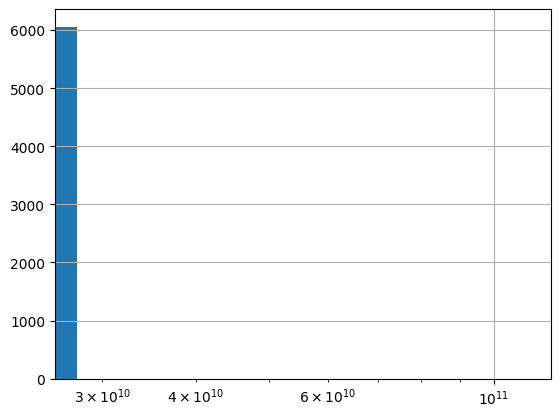

In [133]:
summary_statistics(cars["price"])
cars["price"].hist(bins=4)
plt.xscale("log")
plt.show()

price -> abs(price)
If price is 0 -> price = nan


In [134]:
cars["price"] = abs(cars["price"])
price_is_0 = cars["price"] <= 0
cars.loc[price_is_0, "price"] = np.nan

If price over 1_000_000 -> price = nan


In [135]:
price_over_1_000_000 = cars["price"] >= 1e6
cars.loc[price_over_1_000_000, "price"] = np.nan

If price less than 500 -> price \*= 1000


        brand model    year   mileage    price
5626  Peugeot   206  2012.0   71000.0  26000.0
5413  Peugeot   206  2009.0  193000.0  21500.0
2759  Peugeot   206  2011.0  145000.0  21500.0
1192  Peugeot   206  2005.0  126700.0  21000.0
2465  Peugeot   206  2005.0  126600.0  21000.0
5416  Peugeot   206  2006.0  140000.0  21000.0
5455  Peugeot   206  2006.0  142000.0  21000.0
146   Peugeot   206  2011.0  190000.0  20500.0
2365  Peugeot   206  2000.0  120000.0  20300.0
200   Peugeot   206  2009.0  130000.0  20300.0
3297  Peugeot   206  2009.0  130000.0  20000.0
99    Peugeot   206  2008.0  179000.0  19250.0
2214  Peugeot   206  2006.0  199000.0  19000.0
1269  Peugeot   206  2008.0  291000.0  18500.0
60    Peugeot   206  2002.0  284000.0  18300.0
3020  Peugeot   206  2008.0  300000.0  18200.0
1363  Peugeot   206  2005.0       NaN  18000.0
1271  Peugeot   206  2006.0  263000.0  18000.0
305   Peugeot   206  2013.0  290000.0  17500.0
2597  Peugeot   206  2001.0  180000.0  16500.0
2904  Peugeot

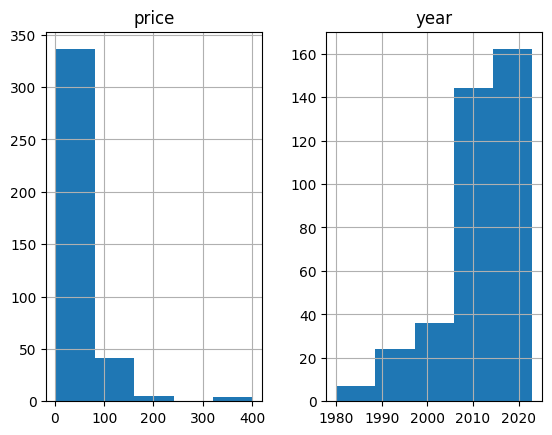

In [136]:
print(
    cars.loc[
        (cars["model"] == "206") & (cars["price"] < 100000),
        ["brand", "model", "year", "mileage", "price"],
    ].sort_values(by=["price", "year"], ascending=[False, True])
)
cars.loc[(cars["price"] > 1) & (cars["price"] < 500), ["price", "year"]].hist(bins=5)
plt.show()

In [137]:
price_less_than_1000 = cars["price"] <= 500
cars.loc[price_less_than_1000, "price"] *= 1000


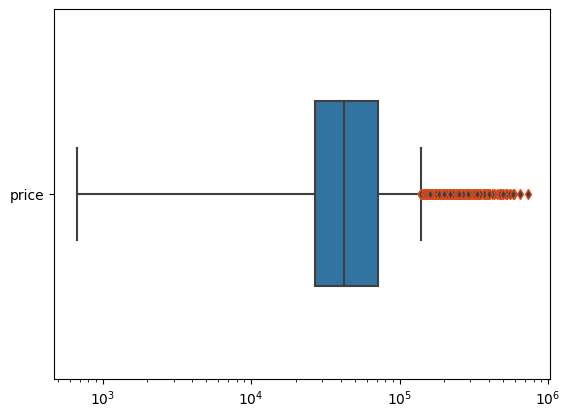

In [138]:
ax = sns.boxplot(
    data=cars[["price"]],
    width=0.5,
    orient="h",
    flierprops=dict(markeredgecolor="#D94D1F"),
)
plt.xscale("log")
plt.show()

price < 4000 -> np.nan


In [139]:
uncoherent_pattern = (
    (cars["price"] == 1234) | (cars["price"] == 1111) | (cars["price"] <= 1000)
)
data = cars.loc[
    uncoherent_pattern,
    ["brand", "model", "year", "mileage", "price"],
].sort_values(by=["price", "year"], ascending=[True, True])
print(data)
cars.loc[
    uncoherent_pattern,
    "price",
] = np.nan

              brand     model    year   mileage   price
1199  Mercedes Benz  Classe S     NaN       NaN   670.0
243      Volkswagen    Golf 6  2023.0       NaN   850.0
244           Isuzu   Trooper  2000.0  200000.0   999.0
3221          Skoda     Fabia  1978.0       NaN  1000.0
2472        Citroen        Bx  1985.0  330000.0  1000.0
...             ...       ...     ...       ...     ...
5680        Citroen  Berlingo  2015.0  234000.0  1234.0
5814           Seat      Leon  2015.0  140000.0  1234.0
3228            Byd        F3  2017.0       NaN  1234.0
1038        Renault      Clio  2021.0   50000.0  1234.0
3070           Ford   Mustang  2021.0   12000.0  1234.0

[140 rows x 5 columns]


              brand         model    year   mileage   price
482          Suzuki       Celerio  2023.0       NaN  1200.0
1270         Toyota          Aygo  2023.0       NaN  3200.0
5696        Citroen         Jumpy  2022.0       NaN  2000.0
2638        Citroen          Nemo  2019.0  180000.0  1500.0
2332         Autres         Autre  2018.0  125000.0  1243.0
1223        Citroen          Nemo  2018.0   56000.0  3000.0
2499        Citroen          Nemo  2018.0   56000.0  3000.0
2704        Citroen          Nemo  2018.0   56000.0  4000.0
1165        Renault          Clio  2017.0   78000.0  4000.0
5864        Peugeot       Partner  2015.0  300000.0  1500.0
1077        Renault        Symbol  2015.0  200000.0  2000.0
235           Dacia        Dokker  2013.0  227000.0  1400.0
1213           Audi            Q5  2010.0       NaN  1050.0
5671        Renault          Clio  2010.0  100000.0  1700.0
61     Autre Marque  Autre Modèle  2009.0  280000.0  1900.0
363            Ford         Focus  2008.

(array([11.,  7.,  2.,  4.,  6.,  3.,  9.]),
 array([1980.        , 1986.14285714, 1992.28571429, 1998.42857143,
        2004.57142857, 2010.71428571, 2016.85714286, 2023.        ]),
 <BarContainer object of 7 artists>)

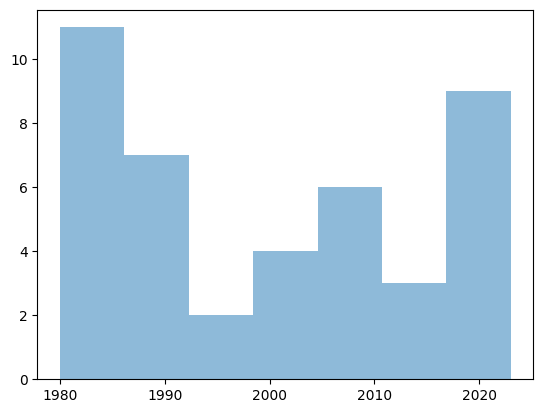

In [140]:
under_4000 = cars["price"] <= 4000

data = cars.loc[
    under_4000,
    ["brand", "model", "year", "mileage", "price"],
].sort_values(by=["year", "price"], ascending=[False, True])
print(data)
plt.hist(data["year"], bins=7, alpha=0.5, label=model)

In [141]:
recent = cars["year"] > 2000
cars.loc[
    under_4000 & recent,
    ["price"],
] = np.nan

price grouped by model


In [142]:
def calIQR(x):
    q3 = x.quantile(0.75)
    q1 = x.quantile(0.25)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (lower_bound, upper_bound)


def callZscore(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return abs((x - mean) / std)
    # return zscore(x)

IQR


In [143]:
cars_grouped = cars.groupby("model")
bounds = cars_grouped["price"].apply(calIQR)
# print(my_dict)

In [144]:
def histogram_by_model(grouped, model, column):
    grouped = cars.groupby("model")
    rows = grouped.get_group(model)
    summary_statistics(rows[column])

    plt.hist(rows[column], bins=7, alpha=0.5, label=model)


def boxplot_by_model(grouped, model, column):
    grouped = cars.groupby("model")

    rows = grouped.get_group(model)
    sns.boxplot(
        data=rows[[column]], orient="h", flierprops=dict(markeredgecolor="#D94D1F")
    )

    plt.show()

 summary statistics
Min: 1499.0
Mean: 21378.18
Max: 199000.0
25th percentile: 14000.0
Median: 18000.0
75th percentile: 20300.0
Interquartile range (IQR): 6300.0


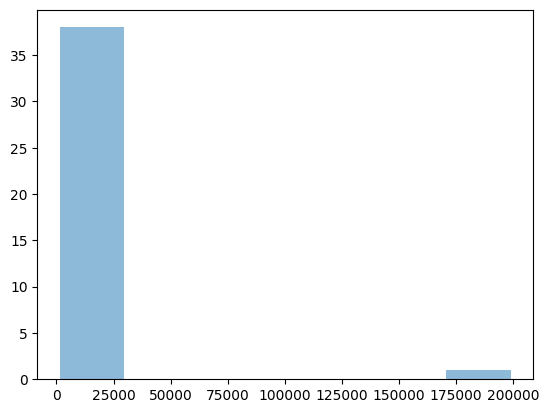

In [145]:
model = "206"
histogram_by_model(cars_grouped, model, "price")
# boxplot_by_model(cars_grouped,model,"price")

In [146]:
models = cars["model"].unique()
lower = bounds[model][0]
upper = bounds[model][1]

# print(lower,upper)

cars.loc[
    (cars["model"] == model) & ((cars["price"] < lower) | (cars["price"] > upper)),
    "price",
] = np.nan


sum = 0
for model in models:
    if model not in bounds.keys():
        continue

    if str(bounds[model][0]) == "nan":
        continue
    lower = bounds[model][0]
    upper = bounds[model][1]

    print(lower, upper)
    out = cars.loc[
        (cars["model"] == model) & ((cars["price"] < lower) | (cars["price"] > upper)),
        "price",
    ]
    sum += out.shape[0]
    out = np.nan


print(sum)
# boxplot_by_model(cars_grouped,"Rio","price")
# histogram_by_model(cars_grouped,model,"price")

78500.0 126500.0
58000.0 82000.0
37000.0 37000.0
4500.0 184500.0
-5000.0 115000.0
-6937.5 57562.5
-85500.0 288500.0
11375.0 236375.0
20750.0 202750.0
13125.0 80125.0
25000.0 105000.0
-58625.0 266375.0
1250.0 127250.0
16875.0 49875.0
6062.5 143562.5
52125.0 78325.0
75000.0 207000.0
17375.0 48375.0
-25000.0 207000.0
-17500.0 74500.0
-17125.0 129875.0
-56687.5 197612.5
-13625.0 65375.0
48625.0 207625.0
-4875.0 118125.0
-13000.0 273000.0
-135250.0 406750.0
7875.0 53675.0
-211250.0 578750.0
20500.0 24500.0
18500.0 75300.0
84000.0 141600.0
19250.0 79650.0
-52000.0 284000.0
36000.0 88000.0
-6000.0 190000.0
4550.0 29750.0
25625.0 106625.0
3125.0 64125.0
15500.0 91500.0
9937.5 62437.5
184050.0 205650.0
205000.0 349000.0
29062.5 102562.5
47750.0 177750.0
-8875.0 188125.0
-72501.875 239501.125
30750.0 78750.0
72000.0 112000.0
95487.5 134187.5
19375.0 60375.0
-500.0 67500.0
32062.5 74562.5
256900.0 256900.0
165000.0 165000.0
1875.0 54875.0
51125.0 74125.0
13125.0 120125.0
87000.0 103000.0
163250.0

In [147]:
data = cars.loc[
    (cars["price"] < 4000),
    ["brand", "model", "year", "mileage", "price"],
].sort_values(by=["price", "year"], ascending=[False, True])
print(data)

           brand    model    year   mileage   price
2601     Peugeot      205  1997.0   30000.0  3800.0
3229     Renault       R9  1984.0  400000.0  3600.0
2245  Volkswagen     Golf  1980.0       NaN  3500.0
283   Volkswagen     Golf  1985.0  300000.0  3500.0
3112     Peugeot     3008  1987.0       NaN  3500.0
1189     Renault       R5  1995.0   50000.0  3300.0
3138     Peugeot      205     NaN       NaN  3300.0
14          Ford   Escort  1987.0  600000.0  3000.0
2260     Renault       R5  1980.0  320000.0  2500.0
469         Fiat      Uno  1988.0  300000.0  2500.0
2925     Renault      R11  1990.0  500000.0  2500.0
5768     Renault       R5  2000.0  120000.0  2300.0
1052  Volkswagen   Golf 2  1980.0  500000.0  2100.0
1362     Renault       R5  1980.0  580000.0  2000.0
5415       Isuzu  Trooper  1990.0   55000.0  2000.0
2419      Autres    Autre     NaN       NaN  2000.0
5806     Renault       R5  1987.0       NaN  1400.0
3009     Renault       R5  1980.0       NaN  1300.0


## z_score


In [148]:
models = cars["model"].unique()
threshold = 2
for model in models:
    if str(model) == "nan":
        continue
    df = cars_grouped.get_group(model)
    df["z_score"] = callZscore(df["price"])
    above_threshold = df["z_score"] > threshold
    outliers = df.loc[
        above_threshold, ["z_score", "price", "year", "mileage", "price_new"]
    ]
    indices = outliers.index.tolist()
    cars.loc[indices, "price"] = np.nan

/tmp/ipykernel_2827/2980954154.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["z_score"] = callZscore(df["price"])
/tmp/ipykernel_2827/2980954154.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["z_score"] = callZscore(df["price"])
/tmp/ipykernel_2827/2980954154.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

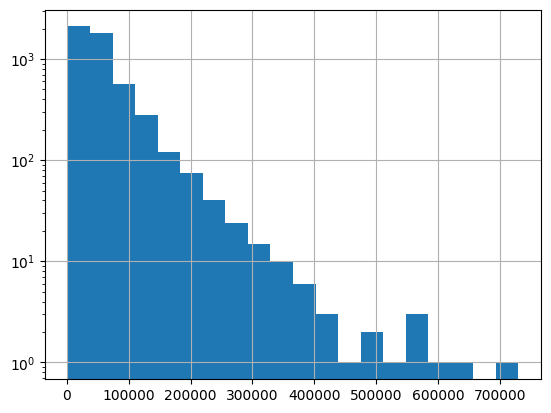

 summary statistics
Min: 1300.0
Mean: 59129.79
Max: 730000.0
25th percentile: 28000.0
Median: 43000.0
75th percentile: 70000.0
Interquartile range (IQR): 42000.0


In [149]:
cars["price"].hist(bins=20)
plt.yscale("log")
plt.show()
summary_statistics(cars["price"])

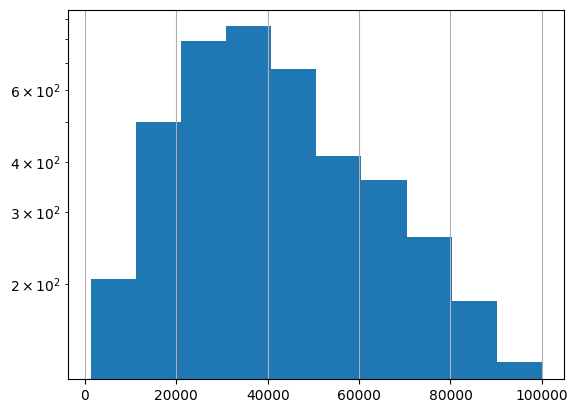

 summary statistics
Min: 1300.0
Mean: 42480.8
Max: 99999.0
25th percentile: 26000.0
Median: 38500.0
75th percentile: 56000.0
Interquartile range (IQR): 30000.0


In [150]:
category1 = cars.loc[cars["price"] < 100_000, "price"]
category2 = cars.loc[cars["price"] >= 100_000, "price"]
category1.hist(bins=10)
plt.yscale("log")
plt.show()
summary_statistics(category1)

In [151]:
cars.loc[cars["price"] > 400_000, ["brand", "model", "year", "price"]]

,brand,model,year,price
122,Jaguar,F Pace,2018.0,450000.0
575,Mercedes Benz,Gle Coupe,2021.0,550000.0
755,Land Rover,Range Rover,2017.0,650000.0
817,Land Rover,Range Rover,2018.0,730000.0
905,Porsche,Cayenne,2015.0,430000.0
1097,Land Rover,Range Rover Velar,2023.0,475000.0
1213,Porsche,911,2017.0,590000.0
1557,Mercedes Benz,Gle Coupe,2017.0,520000.0
1876,Porsche,Cayenne,2018.0,435000.0
1948,Land Rover,Range Rover Velar,2022.0,500000.0


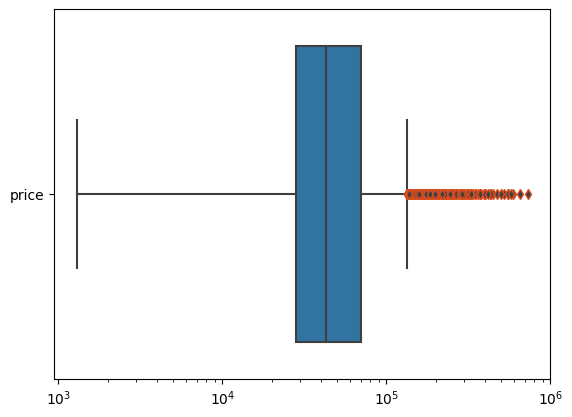

In [152]:
sns.boxplot(
    data=cars[["price"]], orient="h", flierprops=dict(markeredgecolor="#D94D1F")
)
plt.xscale("log")

plt.show()